Acquisition and Analysis of Neural Data 

Exercise 03

Bramantyo Ibrahim Supriyatno

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.linalg import eig

import seaborn as sns
import scipy.io

sns.set(style="darkgrid", context="talk", palette="pastel")
plt.style.use('seaborn')

# Exercise 1

(a)

In [30]:
spike_times = np.loadtxt('SpikeTimes.dat').T/1e3
#spike_times = np.nan_to_num(spike_times, nan=-1)
max_t = 5.5
del_t = 1e-4
num_trial = 100
sr = int(1./del_t)
num_samples = int(max_t*sr)
t = np.arange(0, max_t, step=del_t)

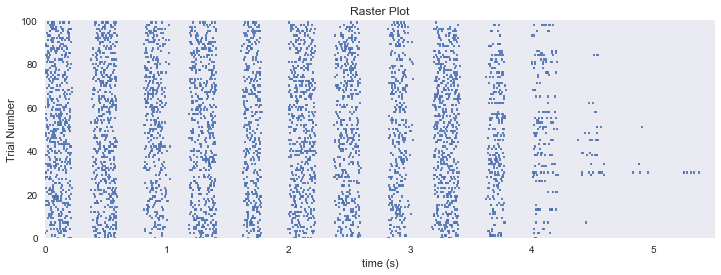

In [31]:
plt.figure(figsize=(12,4))
plt.eventplot(spike_times)
plt.xlim(0, max_t)
plt.ylim(0, num_trial)
plt.title('Raster Plot')
plt.ylabel('Trial Number')
plt.xlabel('time (s)')
plt.grid()
plt.show()

(b)

In [32]:
def plot_isi_hist(spike_times, title='Interspike Interval Histogram', num_bins=200, num_trial = 1):
    spike_diff = np.diff(spike_times).ravel()
    spike_diff = spike_diff[~np.isnan(spike_diff)]

    counts, bins = np.histogram(spike_diff, num_bins)
    trial_norm_counts = counts/num_trial
    plt.figure(figsize=(12,4))
    plt.hist(bins[:-1], bins, weights=trial_norm_counts)
    plt.xlabel('ISI (s)')
    plt.ylabel('Counts')
    plt.title(title)
    plt.grid()
    plt.show()

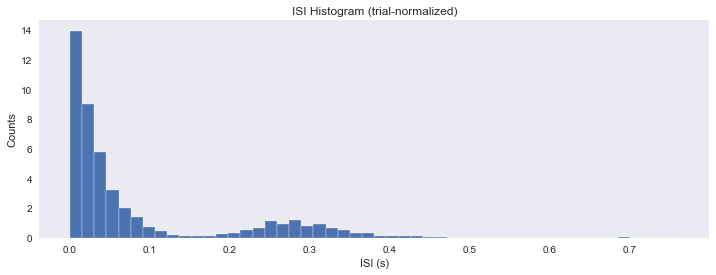

In [33]:
plot_isi_hist(spike_times, title='ISI Histogram (trial-normalized)', num_trial=num_trial, num_bins=50)

the interspike interval are mostly concentrated at 0 second. there is however a significant distribution at 0.3 second which explains the gap that can be seen on the raster plot.

(c)

In [34]:
def get_cv(spike_times):
    spike_diff = np.diff(spike_times).ravel()
    spike_diff = spike_diff[~np.isnan(spike_diff)]

    return spike_diff.std()/spike_diff.mean()

In [35]:
print('trial pooled CV: {}'.format(get_cv(spike_times)))

trial pooled CV: 1.3537882337148048


(d)

In [36]:
def time_to_dirac(data, num_trial, num_samples, del_t):
    data_pp = np.nan_to_num(data, nan=-1)
    spike_del = np.zeros((num_trial,num_samples))

    for i in range(num_trial):
        temp_idx = data_pp[i,:]
        temp_idx = temp_idx[temp_idx > 0]
        temp_idx = (temp_idx / del_t).astype(int)
        spike_del[i,temp_idx] = 1
    
    return spike_del

In [37]:
spike_dirac = time_to_dirac(spike_times, num_trial, num_samples, del_t)

In [38]:
def fano_factor(dirac_data, wsize_s, num_trial, num_samples, del_t, is_trial_resolve = False):
    if is_trial_resolve:
        ax = 1
    else:
        ax = 0

    wsize = int(wsize_s / del_t)
    num_window = int(num_samples / wsize)
    ns = []
    for i  in range(num_window):
        window = dirac_data[:,i*wsize:(i+1)*wsize]
        n = np.sum(window, axis=1)
        ns.append(n)
    ns = np.array(ns).T
    trial_mean = np.mean(ns, axis = ax)
    trial_var = np.var(ns, axis = ax) 
    return np.divide(trial_var, trial_mean)
    

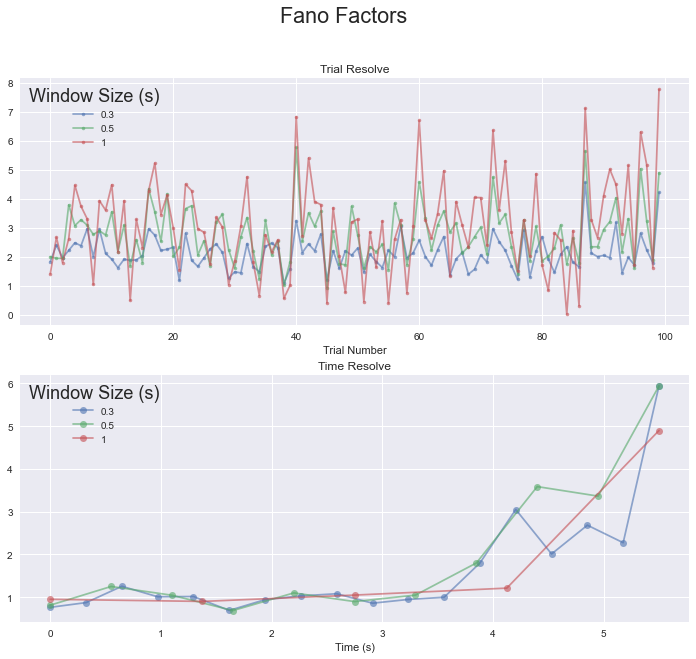

In [39]:
wsizes = [0.3, 0.5, 1]

fig, ax = plt.subplots(2,1, figsize=(12,10))
fig.suptitle('Fano Factors')
for wsize in wsizes:
    time_res = fano_factor(spike_dirac, wsize, num_trial, num_samples, del_t)
    trial_res = fano_factor(spike_dirac, wsize, num_trial, num_samples, del_t, True)
    ax[0].plot(trial_res, marker='.', label=str(wsize), alpha=0.6)

    t = np.linspace(0, max_t, time_res.shape[0])
    ax[1].plot(t, time_res, marker='o', label=str(wsize), alpha=0.6)
ax[0].set_title('Trial Resolve')
ax[0].set_xlabel('Trial Number')
ax[0].legend(title='Window Size (s)')

ax[1].set_title('Time Resolve')
ax[1].set_xlabel('Time (s)')
ax[1].legend(title='Window Size (s)')

plt.show()

Discussion:

The width of the time window affect fano factor for trial and time resolve in a conversing way. For trial resolve, bigger time windows gives since more fluctuative figure. In contrast, for time resolve, larger time window are relatively stable compared to other.

# Exercise 2

(a)

In [43]:
mat_data = scipy.io.loadmat('PoissonSpikeTrains.mat')

spike_times_hom = mat_data['SpikeTimes_hom']/1e3
spike_times_inh = mat_data['SpikeTimes_inh']/1e3

max_t_hom = spike_times_hom.max()
max_t_inh = spike_times_inh.max()

del_t = 1e-4
num_bins = 32

num_samples_hom = int(np.ceil(max_t_hom / del_t))
num_samples_inh = int(np.ceil(max_t_inh / del_t))

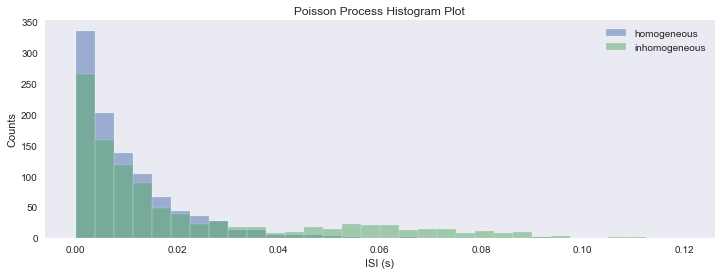

In [44]:
spike_diff_hom = np.diff(spike_times_hom).ravel()
spike_diff_hom = spike_diff_hom[~np.isnan(spike_diff_hom)]
counts_hom, bins_hom = np.histogram(spike_diff_hom, num_bins, range=(0,0.12))

spike_diff_inh = np.diff(spike_times_inh).ravel()
spike_diff_inh = spike_diff_inh[~np.isnan(spike_diff_inh)]
counts_inh, bins_inh = np.histogram(spike_diff_inh, num_bins, range=(0,0.12))


plt.figure(figsize=(12,4))
plt.title('Poisson Process Histogram Plot')

plt.hist(bins_hom[:-1], bins_hom, weights=counts_hom, alpha=0.5, label='homogeneous')


plt.hist(bins_inh[:-1], bins_inh, weights=counts_inh, alpha=0.5, label='inhomogeneous')

plt.xlabel('ISI (s)')
plt.ylabel('Counts')
plt.legend()
plt.grid()

plt.legend()
plt.show()

inhomogeneous poisson process seems to have second distribution at 0.06, while homogeneous seems to have exponentially decreasing distribution

(b)

In [45]:
print('CV for Homogeneous Poisson Process: {}'.format(get_cv(spike_times_hom)))
print('CV for Inhomogeneous Poisson Process: {}'.format(get_cv(spike_times_inh)))

CV for Homogeneous Poisson Process: 1.0126965180137775
CV for Inhomogeneous Poisson Process: 1.1805742873016383


In [47]:
hom_dirac = time_to_dirac(spike_times_hom, 1, num_samples_hom, del_t)
inh_dirac = time_to_dirac(spike_times_inh, 1, num_samples_inh, del_t)
hom_fano = float(fano_factor(hom_dirac, 0.1, 1, num_samples_hom, del_t, True))
inh_fano = float(fano_factor(inh_dirac, 0.1, 1, num_samples_hom, del_t, True))

print('fano factor of homogeneous poisson process: {}'.format(hom_fano))
print('fano factor of inhomogeneous poisson process: {}'.format(inh_fano))

fano factor of homogeneous poisson process: 1.0760095747095602
fano factor of inhomogeneous poisson process: 1.0834641548927262


(c)

In [48]:
hom_firing_rate = np.sum(hom_dirac) / max_t_hom
inh_firing_rate = np.sum(inh_dirac) / max_t_inh
print('average firing rate of homogeneous poisson process: {}'.format(hom_firing_rate))
print('average firing rate of inhomogeneous poisson process: {}'.format(inh_firing_rate))

average firing rate of homogeneous poisson process: 100.74812523960486
average firing rate of inhomogeneous poisson process: 49.42815474865771


In [49]:
def plot_autocorrelation(dirac_deltas, max_t, xlim2=2, ylim2=2, title = 'Autocorrelation'):
    corr = np.correlate(dirac_deltas.ravel(), dirac_deltas.ravel(), 'full') / max_t
    t = np.linspace(-max_t, max_t, corr.shape[0])

    fig, ax = plt.subplots(2,1, figsize=(12,8))
    fig.suptitle(title)
    ax[0].plot(t, corr)
    ax[0].set_xlabel('τ (s)')

    ax[1].plot(t, corr)
    ax[1].set_xlabel('τ (s)')
    ax[1].set_ylim(0,ylim2)
    ax[1].set_xlim(-xlim2,xlim2)

    plt.show()

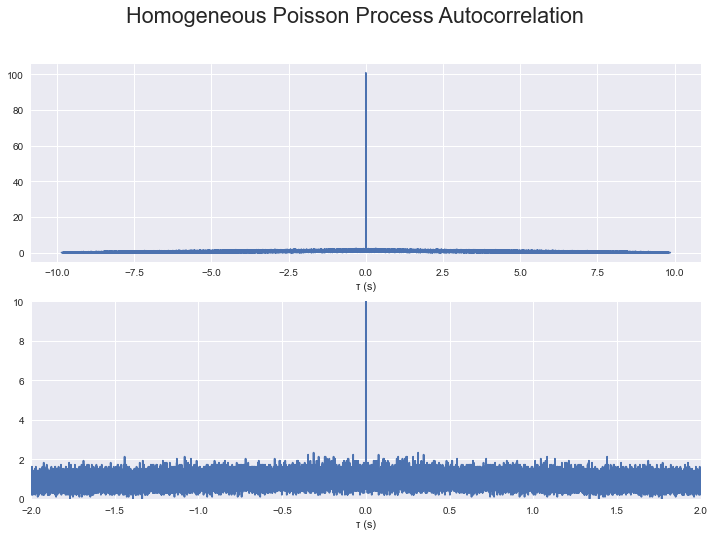

In [50]:
plot_autocorrelation(hom_dirac, max_t_hom, xlim2=2, ylim2=10, title='Homogeneous Poisson Process Autocorrelation')

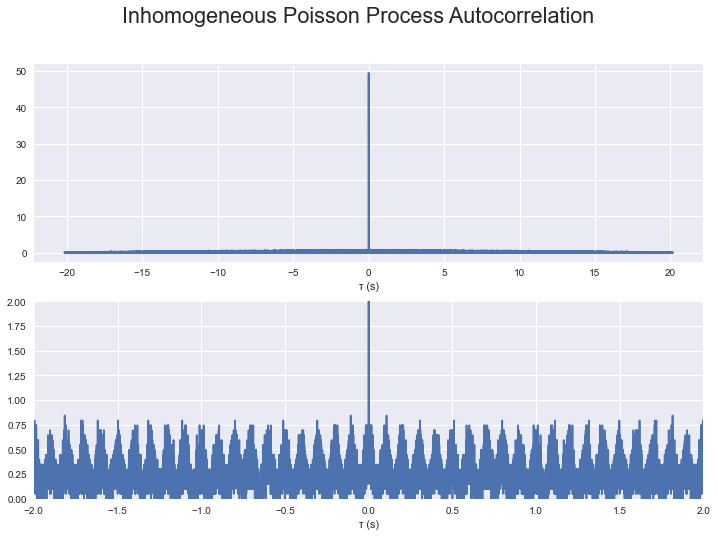

In [51]:
plot_autocorrelation(inh_dirac, max_t_inh, xlim2=2, ylim2=2, title = 'Inhomogeneous Poisson Process Autocorrelation')

(d)

Both fano factor and CV are computed within a window. Using window basically change the statistics of the spikes. therefore the values deviate 

# Exercise 3

(a)

In [54]:
rates_ref = [10, 50, 100, 200, 500, 1000]
del_t = 1e-3
ref_spike_times = scipy.io.loadmat('PoissonSpikeTrains.mat')['SpikeTimes_ref'].T / 1e3
fano_s_size = 0.1

spike_trains = []
ref_diracs = []
max_ts = []
r_effs = []
num_samples = []
cvs = [] 
fanos = []


for i in range (ref_spike_times.shape[0]):
    data =  ref_spike_times[[i],:]
    max_t = data.max()
    num_sample = int(np.ceil(max_t / del_t))
    dirac = time_to_dirac(data, 1, num_sample, del_t)

    spike_trains.append(data)
    max_ts.append(max_t)
    num_samples.append(num_samples)
    ref_diracs.append(dirac)
    r_effs.append(dirac.sum() / max_t)
    cvs.append(get_cv(data))
    fanos.append(fano_factor(dirac, fano_s_size, 1, num_sample, del_t, True))

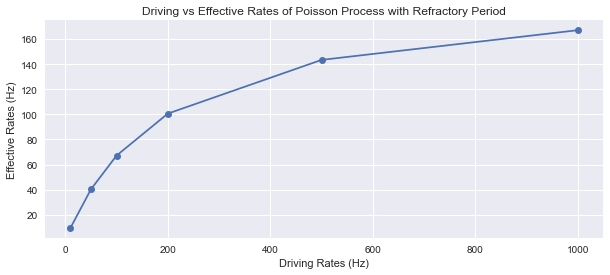

In [55]:
plt.figure(figsize = (10,4))
plt.plot(rates_ref, r_effs, marker='o')
plt.xlabel('Driving Rates (Hz)')
plt.ylabel('Effective Rates (Hz)')
plt.title('Driving vs Effective Rates of Poisson Process with Refractory Period')
plt.show()

the effective rates seems to approach 170 Hz for higher driving rate

(b)

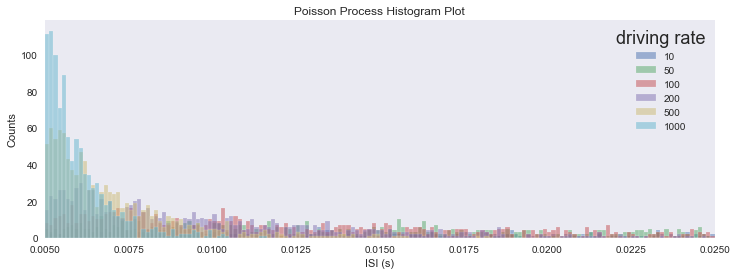

In [56]:
plt.figure(figsize=(12,4))
for i,st in enumerate(spike_trains):
    #plot_isi_hist(st, num_bins=48, title='ISI Histogram for Driving Rate: {} Hz'.format(rates_ref[i]))


    spike_diff = np.diff(st).ravel()
    spike_diff = spike_diff[~np.isnan(spike_diff)]
    counts, bins = np.histogram(spike_diff, 200, range=(0,0.025))
    plt.hist(bins[:-1], bins, weights=counts, alpha=0.5, label=str(rates_ref[i]))

plt.title('Poisson Process Histogram Plot')
plt.xlabel('ISI (s)')
plt.ylabel('Counts')
plt.legend(title='driving rate')
plt.grid()
plt.xlim(0.005, 0.025)
plt.show()

(c)

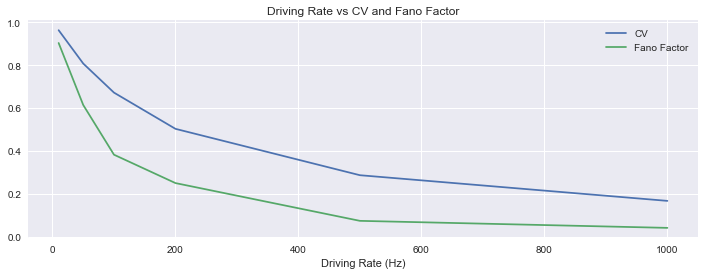

In [57]:
plt.figure(figsize=(12,4))
plt.plot(rates_ref, cvs, label='CV')
plt.plot(rates_ref, fanos, label='Fano Factor')
plt.title('Driving Rate vs CV and Fano Factor')
plt.xlabel('Driving Rate (Hz)')
plt.legend()
plt.show()

Both CV and Fano factor measure how regular the spike train and the ISI respectively. higher driving rate will increase likelihood of concurrent spikes within a range. refractory period will then restricts that and forcing the spike to happen after the period. this results in even more higher likelihood and eventually regular firing pattern.   

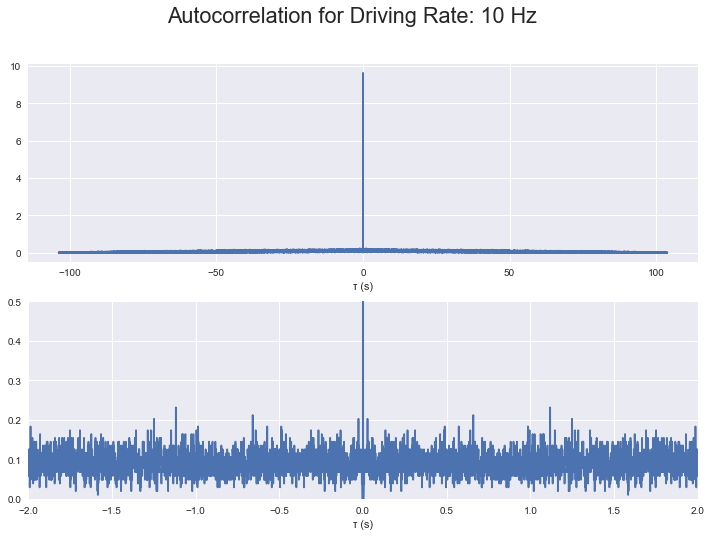

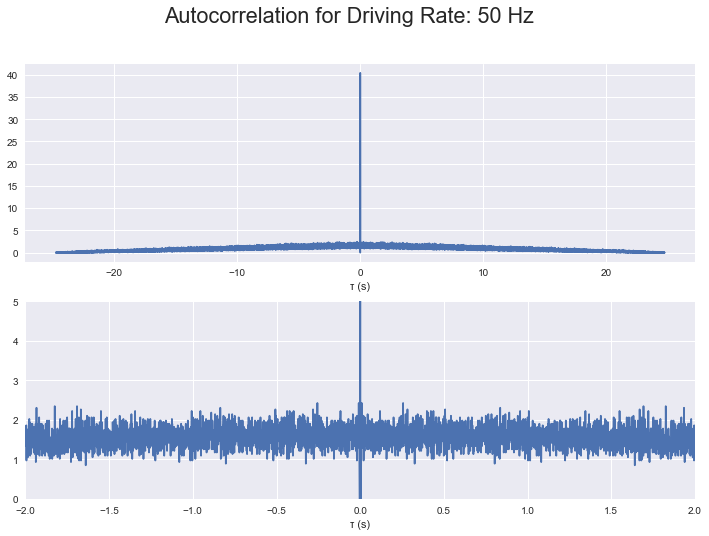

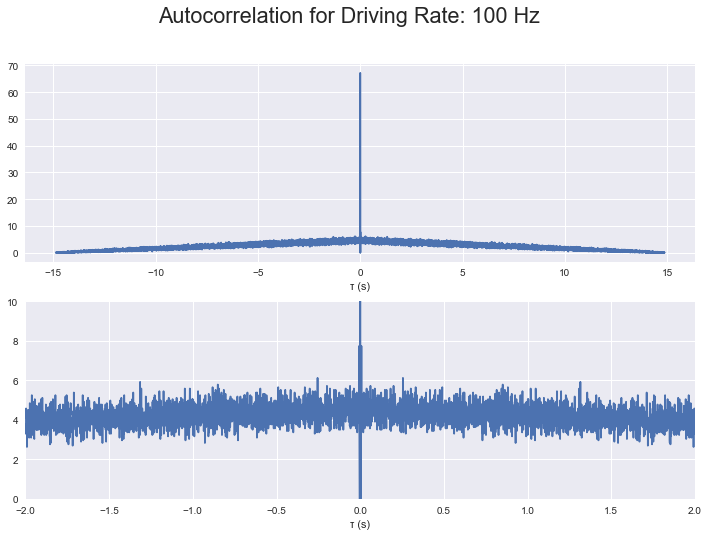

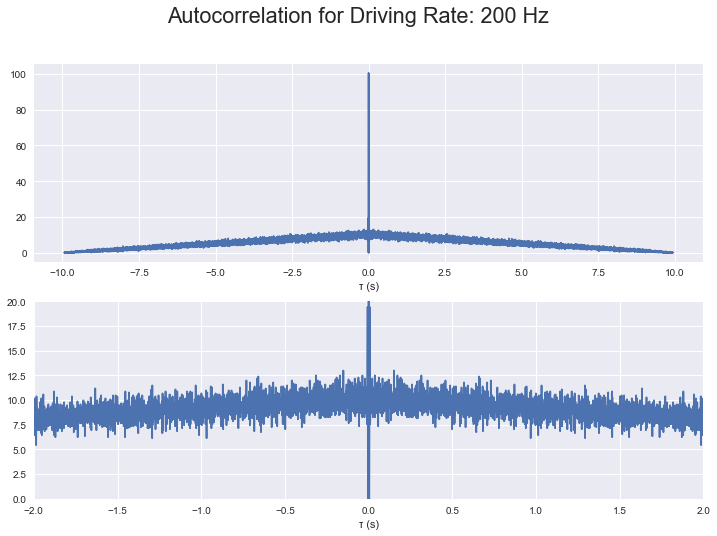

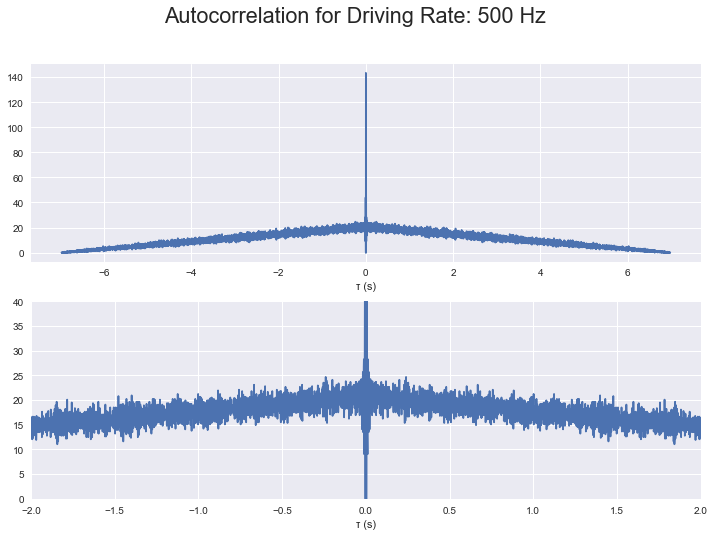

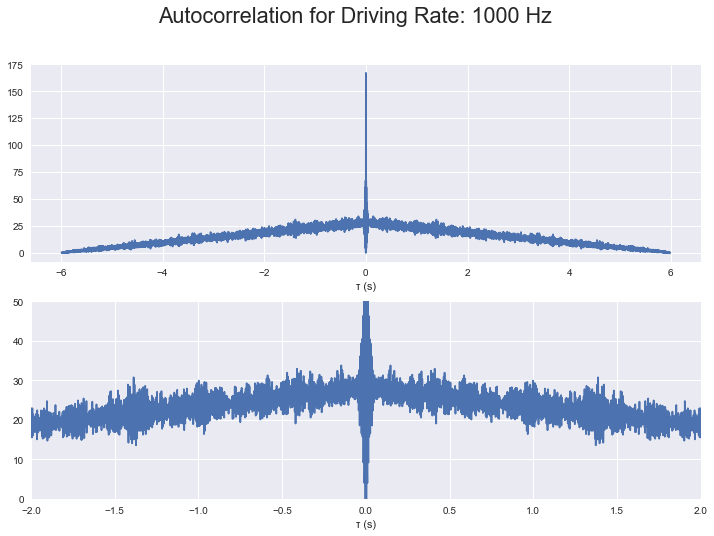

In [58]:
ylims = [0.5, 5, 10, 20, 40, 50]
for i,dirac in enumerate(ref_diracs):
    plot_autocorrelation(dirac, max_ts[i], ylim2 = ylims[i], title = 'Autocorrelation for Driving Rate: {} Hz'.format(rates_ref[i]))

higher driving rate yields a more regular spike trains. the peaks are the result of the regularity. 